<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [284]:
from pymongo import MongoClient
connection = MongoClient(
    host="research.cassee.dev:27017",
    username="read-shark",
    password="msr2021shark")

print(f"Databases present are {connection.list_database_names()}")

db = connection.smartshark_2_1

project = db.project.find_one({})

repos = list(db.vcs_system.find({'project_id':project['_id']}))

print(f"Found {len(repos)} repos")

commits = db.commit.count_documents({'vcs_system_id': {'$in': [x["_id"] for x in repos]}})

print(f"There are {commits} commits for {project['name']}")

Databases present are ['smartshark_2_1']
Found 1 repos
There are 7222 commits for commons-math


In [385]:
import pandas as pd
from bson.json_util import dumps
from json import loads
import bson
from matplotlib import pyplot as plt

In [316]:
db = connection['smartshark_2_1']
print(db)

Database(MongoClient(host=['research.cassee.dev:27017'], document_class=dict, tz_aware=False, connect=True), 'smartshark_2_1')


In [317]:
def convert_object_ids(df, keys):
    for x in keys:
        df[x] = (df.apply(lambda y: loads(dumps(y[x] if type(y[x]) == bson.objectid.ObjectId else {'$oid': None}))['$oid'], axis=1))


In [318]:
# Get the people dataset and convert the ObjectIds to strings
df_people = pd.DataFrame(list(db.people.find({})))
convert_object_ids(df_people, ['_id'])

In [319]:
# Get the project dataset and convert the ObjectIds to strings
df_project = pd.DataFrame(list(db.project.find({})))
convert_object_ids(df_project, ['_id'])

In [320]:
# Get the PR dataset and convert the ObjectIds to strings
df_pull_request = pd.DataFrame(list(db.pull_request.find({})))
convert_object_ids(df_pull_request, [
    '_id',
    # 'assignee_id',
    'creator_id',
    # 'merge_commit_id',
    'pull_request_system_id',
    # 'requested_reviewer_ids',
    # 'source_commit_id',
    # 'target_commit_id'
])

In [321]:
# Get the PR_review dataset and convert the ObjectIds to strings
df_pull_request_review = pd.DataFrame(list(db.pull_request_review.find({})))
convert_object_ids(df_pull_request_review, [
    '_id',
    'creator_id',
    # 'pull_request_commit_id',
    'pull_request_id'
])

In [329]:
# Create the same identifier so that we can join
df_pull_request['pull_request_id'] = df_pull_request['_id']

In [388]:
df_approved_prs = df_pull_request_review.where(df_pull_request_review['state'] == 'APPROVED').dropna(subset=['_id'])
df_closed_prs = df_pull_request_review.where(df_pull_request_review['state'] == 'COMMENTED').dropna(subset=['_id'])
df_approved_prs.head(3)

,_id,pull_request_id,external_id,state,description,creator_id,submitted_at,author_association,commit_sha,pull_request_commit_id
0,5ff188803fba52c925be898d,5ff1887f3fba52c925be898c,143337164,APPROVED,"The code looks good, ASN.1-like encoding is a ...",5ff18872c26a57681e7b6d2b,2018-08-03 21:41:31,CONTRIBUTOR,b506949b50d56482e5bdf1123f99a7f2b952f25c,NaN
37,5ff1919ecbcaee8d21c67e79,5ff1919ccbcaee8d21c67e75,489446018,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-16 09:32:52,CONTRIBUTOR,a309b67d74c2083d7808d1f7a6aaff22a2a75dd7,5ff1919dcbcaee8d21c67e76
38,5ff191a0cbcaee8d21c67e82,5ff1919ecbcaee8d21c67e7f,479608653,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-01 10:28:43,CONTRIBUTOR,c21157ad10224d78291b3433914847f9227f038d,5ff1919fcbcaee8d21c67e80


In [394]:
df_approved_prs__annotated_with_pr_creator = pd.merge(df_approved_prs, df_pull_request, on='pull_request_id')
df_closed_prs__annotated_with_pr_creator = pd.merge(df_closed_prs, df_pull_request, on='pull_request_id')

In [378]:
df_approved_prs__annotated_with_pr_creator.head(3)

,_id_x,pull_request_id,external_id_x,state_x,description_x,creator_id_x,submitted_at,author_association_x,commit_sha,pull_request_commit_id,...,source_branch,source_commit_sha,target_repo_url,target_branch,target_commit_sha,source_commit_id,target_commit_id,merge_commit_id,assignee_id,lock_reason
0,5ff188803fba52c925be898d,5ff1887f3fba52c925be898c,143337164,APPROVED,"The code looks good, ASN.1-like encoding is a ...",5ff18872c26a57681e7b6d2b,2018-08-03 21:41:31,CONTRIBUTOR,b506949b50d56482e5bdf1123f99a7f2b952f25c,NaN,...,master,89583444040dc5423bb143435f23ae0814f24542,https://github.com/apache/ant-ivy,master,89583444040dc5423bb143435f23ae0814f24542,NaN,NaN,NaN,NaN,NaN
1,5ff1919ecbcaee8d21c67e79,5ff1919ccbcaee8d21c67e75,489446018,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-16 09:32:52,CONTRIBUTOR,a309b67d74c2083d7808d1f7a6aaff22a2a75dd7,5ff1919dcbcaee8d21c67e76,...,WSS-678,a309b67d74c2083d7808d1f7a6aaff22a2a75dd7,https://github.com/apache/ws-wss4j,master,1765c4149d700cac8aea5c1a3b78f2bdee8b6e71,NaN,NaN,NaN,NaN,NaN
2,5ff191a0cbcaee8d21c67e82,5ff1919ecbcaee8d21c67e7f,479608653,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-01 10:28:43,CONTRIBUTOR,c21157ad10224d78291b3433914847f9227f038d,5ff1919fcbcaee8d21c67e80,...,wss4j-ws-security-common,c21157ad10224d78291b3433914847f9227f038d,https://github.com/apache/ws-wss4j,master,e9c20e63dc1694dbc5e116e4c9e82190aa81320a,NaN,NaN,NaN,NaN,NaN


In [386]:
# Get the approved PR's that were merged by someone that is not the same person as the one that opened the request
approved_pull_requests_closed_by_different_person = df_approved_prs__annotated_with_pr_creator.where(df_approved_prs__annotated_with_pr_creator['creator_id_x'] != df_approved_prs__annotated_with_pr_creator['creator_id_y'])

approved_pull_requests_closed_by_different_person[['creator_id_x', 'creator_id_y']]

,creator_id_x,creator_id_y
0,5ff18872c26a57681e7b6d2b,5ff1887dc26a57681e7b6ee1
1,5b4db0dc30a71b06bce03054,5f0d6a7baf02e2d6de888cd0
2,5b4db0dc30a71b06bce03054,5f0d6a7baf02e2d6de888cd0
3,5b4db0dc30a71b06bce03054,5ff191a2c26a57681e7b9533
4,5b4db0dc30a71b06bce03054,5ff191a2c26a57681e7b9533
...,...,...
19773,5b4db0dc30a71b06bce03054,5f0d6a7baf02e2d6de888cd0
19774,5b4db0dc30a71b06bce03054,5f0d6a7baf02e2d6de888cd0
19775,59bc2341f2a4565fe9cfaace,60fd84a0f73e2aa3902dad2a
19776,59bc2341f2a4565fe9cfaace,60fd84a5f73e2aa3902dc6d2


In [395]:
# Get the PR's that were merged by someone that is not the same person as the one that opened the request
closed_pull_requests_closed_by_different_person = df_approved_prs__annotated_with_pr_creator.where(df_closed_prs__annotated_with_pr_creator['creator_id_x'] != df_closed_prs__annotated_with_pr_creator['creator_id_y'])

closed_pull_requests_closed_by_different_person[['creator_id_x', 'creator_id_y']]

,creator_id_x,creator_id_y
0,NaN,NaN
1,5b4db0dc30a71b06bce03054,5f0d6a7baf02e2d6de888cd0
2,5b4db0dc30a71b06bce03054,5f0d6a7baf02e2d6de888cd0
3,5b4db0dc30a71b06bce03054,5ff191a2c26a57681e7b9533
4,5b4db0dc30a71b06bce03054,5ff191a2c26a57681e7b9533
...,...,...
19773,NaN,NaN
19774,NaN,NaN
19775,NaN,NaN
19776,59bc2341f2a4565fe9cfaace,60fd84a5f73e2aa3902dc6d2


In [391]:
approved_pull_requests_closed_by_different_person.head(3)

,_id_x,pull_request_id,external_id_x,state_x,description_x,creator_id_x,submitted_at,author_association_x,commit_sha,pull_request_commit_id,...,source_branch,source_commit_sha,target_repo_url,target_branch,target_commit_sha,source_commit_id,target_commit_id,merge_commit_id,assignee_id,lock_reason
0,5ff188803fba52c925be898d,5ff1887f3fba52c925be898c,143337164,APPROVED,"The code looks good, ASN.1-like encoding is a ...",5ff18872c26a57681e7b6d2b,2018-08-03 21:41:31,CONTRIBUTOR,b506949b50d56482e5bdf1123f99a7f2b952f25c,NaN,...,master,89583444040dc5423bb143435f23ae0814f24542,https://github.com/apache/ant-ivy,master,89583444040dc5423bb143435f23ae0814f24542,NaN,NaN,NaN,NaN,NaN
1,5ff1919ecbcaee8d21c67e79,5ff1919ccbcaee8d21c67e75,489446018,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-16 09:32:52,CONTRIBUTOR,a309b67d74c2083d7808d1f7a6aaff22a2a75dd7,5ff1919dcbcaee8d21c67e76,...,WSS-678,a309b67d74c2083d7808d1f7a6aaff22a2a75dd7,https://github.com/apache/ws-wss4j,master,1765c4149d700cac8aea5c1a3b78f2bdee8b6e71,NaN,NaN,NaN,NaN,NaN
2,5ff191a0cbcaee8d21c67e82,5ff1919ecbcaee8d21c67e7f,479608653,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-01 10:28:43,CONTRIBUTOR,c21157ad10224d78291b3433914847f9227f038d,5ff1919fcbcaee8d21c67e80,...,wss4j-ws-security-common,c21157ad10224d78291b3433914847f9227f038d,https://github.com/apache/ws-wss4j,master,e9c20e63dc1694dbc5e116e4c9e82190aa81320a,NaN,NaN,NaN,NaN,NaN


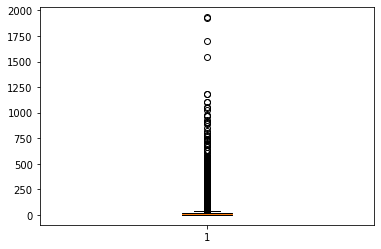

In [410]:

approved_pull_requests_closed_by_different_person['review_time'] = (approved_pull_requests_closed_by_different_person.apply(lambda x: (x['submitted_at'] - x['created_at']).days if x['created_at'] and x['submitted_at'] else None, axis=1))
approved_review_times = approved_pull_requests_closed_by_different_person.where(approved_pull_requests_closed_by_different_person['review_time'] > 0).dropna(subset=['review_time'])[['review_time']]
plot = plt.boxplot(x=approved_review_times)


In [411]:
mean_number_of_days_for_approved_prs = approved_review_times.mean()
mean_number_of_days_for_approved_prs

review_time    26.747218
dtype: float64

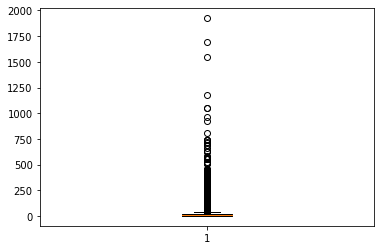

In [407]:
closed_pull_requests_closed_by_different_person['review_time'] = (closed_pull_requests_closed_by_different_person.apply(lambda x: (x['submitted_at'] - x['created_at']).days if x['created_at'] and x['submitted_at'] else None, axis=1))
closed_review_times = closed_pull_requests_closed_by_different_person.where(closed_pull_requests_closed_by_different_person['review_time'] > 0).dropna(subset=['review_time'])[['review_time']]
plot = plt.boxplot(x=closed_review_times)

In [408]:
mean_number_of_days_for_closed_prs = closed_review_times.mean()
mean_number_of_days_for_closed_prs

review_time    27.026969
dtype: float64

In [404]:
closed_pull_requests_closed_by_different_person.where(closed_pull_requests_closed_by_different_person['review_time'] > 0).dropna(subset=['review_time'])[['review_time']]

,review_time
4,7.0
5,76.0
7,5.0
12,2.0
14,20.0
...,...
19766,4.0
19767,67.0
19768,73.0
19769,98.0
